In [1]:
# Import necessary libraries and packages
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import warnings
from math import exp
from numpy import log

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from scipy import stats

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
# Preferred settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)


In [2]:
#import temperature dataset
data = pd.read_csv('../Data/Indicators/tas_timeseries_annual_cru_1901-2020_IND.csv')

#Observe data shape
print(data.shape)

(120, 46)


## Data Cleaning and Preprocessing

In [3]:
#load data
df_India = data

#only include India's temperature data 
df_India = df_India[['year', 'India']]
df_India

,year,India
0,1901,24.26
1,1902,24.52
2,1903,23.96
3,1904,24.02
4,1905,23.87
...,...,...
115,2016,25.27
116,2017,25.15
117,2018,25.00
118,2019,24.94


We convert both into a indexed dataframe to concatenate the dataframes later for multivariate forecasting

In [4]:
#Convert year to index
df_India.set_index('year', inplace=True)

#Convert year to DateTime object
df_India.index = pd.to_datetime(df_India.index, format='%Y')


In [5]:
#observe updated df
df_India.head(5)

,India
year,
1901-01-01,24.26
1902-01-01,24.52
1903-01-01,23.96
1904-01-01,24.02
1905-01-01,23.87


Since we only try to forecast the change in temperature with respect to changing emission patterns, we obtain difference the data to make it a dataset of change in temperature

In [6]:
df_India.rename(columns = {'India':'temperature'}, inplace=True)
df_India

,temperature
year,
1901-01-01,24.26
1902-01-01,24.52
1903-01-01,23.96
1904-01-01,24.02
1905-01-01,23.87
...,...
2016-01-01,25.27
2017-01-01,25.15
2018-01-01,25.00


In [7]:
#check dtypes
df_India.dtypes

temperature    float64
dtype: object

In [8]:
#check null values
df_India.isnull().sum()

temperature    0
dtype: int64

In [9]:
df_India.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 1901-01-01 to 2020-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  120 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [10]:
df_India.describe()

,temperature
count,120.000000
mean,24.393750
std,0.368723
min,23.470000
25%,24.117500
50%,24.340000
75%,24.652500
max,25.470000


## Visualisation

<AxesSubplot:xlabel='year'>

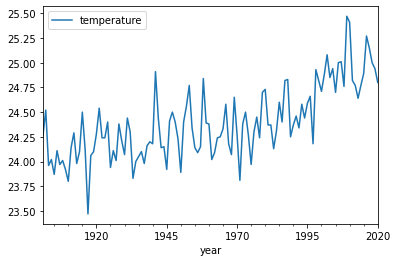

In [11]:
#observe co2 emissions
df_India['temperature'].plot(legend = True)

## Exploratory Data Analysis 

**Reviewing plots of the density of observations can provide further insight into the structure of the data**

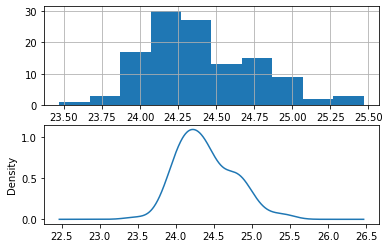

In [12]:
#observe density of per capita emissions
pyplot.figure(1)
pyplot.subplot(211)
df_India.temperature.hist()
pyplot.subplot(212)
df_India.temperature.plot(kind='kde')
pyplot.show()

From the above graphs we can observe, 
- The distribution is not perfectly Gausian (normal distribution)
- The temperature distribution is partially skewed to right
- Transformations might be useful prior to modelling

**Reviewing Box plot of emissions over decades provides insight into the trend and seasonality of the data**

<AxesSubplot:xlabel='year', ylabel='temperature'>

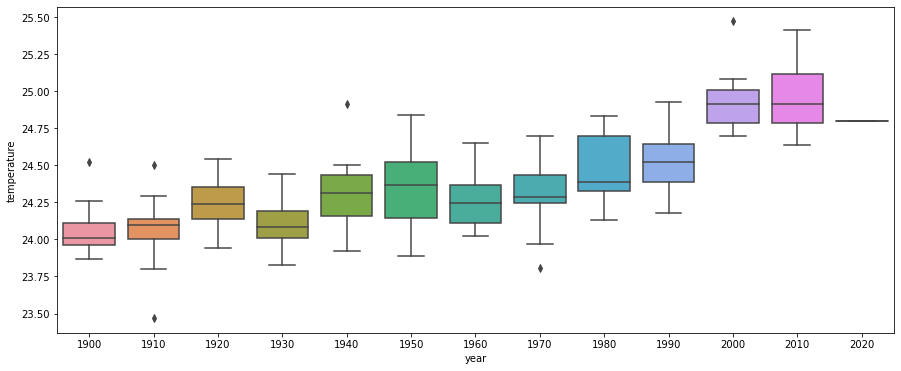

In [13]:
#observe box plots of temperature change
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(df_India.temperature.index.year // 10 * 10, df_India.temperature, ax=ax)

From the above plot we can observe,
- Median values across decade shows irregular rise and fall in temperature
- Disproportionate change in temperature

**Distribution and Normality Test**

Kurtosis of normal distribution 0.006866456551592126
Skewness of normal distribution 0.5245352319069865


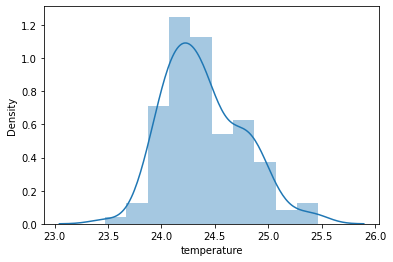

In [14]:
#observe distribution and normality of emissions of temperature change
sns.distplot(df_India.temperature);
stats.normaltest(df_India.temperature)
print('Kurtosis of normal distribution {}'.format(stats.kurtosis(df_India.temperature)))
print( 'Skewness of normal distribution {}'.format(stats.skew(df_India.temperature)))

> - **Kurtosis** describes heaviness of the tails of distribution -  A neagtive value mean that data has ligh tails
> - **Skewness** - distribution is approximately similar

Lets observe the temperature distribution before hand

Normal probability plot shows that dataset has almost regular distribution, with trends

,count,mean,std,min,25%,50%,75%,max
temperature,120.0,24.39375,0.368723,23.47,24.1175,24.34,24.6525,25.47


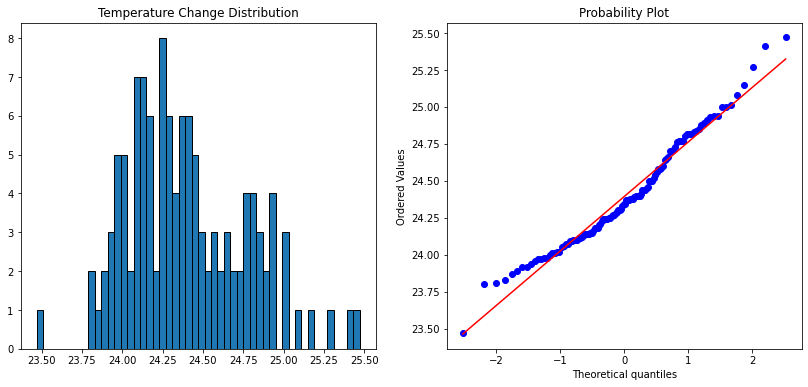

In [15]:
#observe distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df_India.temperature.hist(bins=50,edgecolor='black', grid=False)
plt.title('Temperature Change Distribution')

plt.subplot(1,2,2)
stats.probplot(df_India.temperature, plot=plt);
#print("Skewness: %f" % df['Consumption'].skew())
#print("Kurtosis: %f" % df['Consumption'].kurt())
df_India.describe().transpose()

**Before starting to analyse the stationarity of data, lets need to understand the trend, seasonality and bias of our data by Decomposing** 

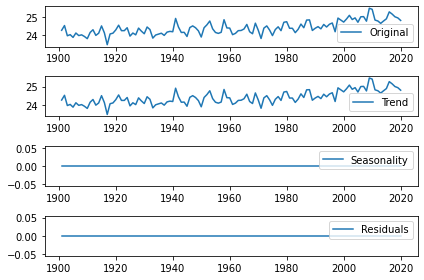

In [16]:
#observe trend and seasonality of temperature
from pylab import rcParams
decomposition = sm.tsa.seasonal_decompose(df_India.temperature, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_India.temperature, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

With Observations from decomposing we observe,
- No seasonal characteristics of Data
- Constant residual
- wave form - irregular trend

**Check Stationarity**

Lets observe stationarity of temperature and emissions data separately

In [61]:
#Perform ADF test for temperature change
test_result = adfuller(df_India['temperature'])
df_result = pd.Series(test_result[0:4], index=['ADF Statistic','p-value','#Lags Used','No. of Observations Used'])
df_result

ADF Statistic                -0.333217
p-value                       0.920666
#Lags Used                    6.000000
No. of Observations Used    113.000000
dtype: float64

With p-value of 0.92 ( <0.05), we cannot reject that null hypothesis that this data is stationary.

There is a presence of unit root in our data

## Build Model

we triend many differenct p,d, and q parameters for an ARIMA model on our loggedm data. The below parameters yielded best results

In [62]:
#building the auto-arima model to compare our observed ordered
from pmdarima.arima import auto_arima
model = auto_arima(df_India,
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True)
model.fit(df_India)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8.677, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.150, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.615, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15.309, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.177, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6.851, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8.852, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12.013, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=12.214, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9.190, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10.695, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9.804, Time=0.06 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 1.903 seconds


ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

**Re-Fit Models to Train-Test Split Data**

In [19]:
# Train-test split
x = df_India.index
y = df_India['temperature']

train = df_India.loc[:'1991-01-01']
test = df_India.loc['1991-01-01':]

x_train, x_test = train.index, test.index
y_train, y_test = train['temperature'], test['temperature']

In [56]:
#initiate Model
ar_mod = ARIMA (y_train[2:], order=(0,2,1))

#Fit Model
mod_fit = ar_mod.fit()

#Observe summary statistics
mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            temperature   No. Observations:                   89
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 -21.549
Date:                Thu, 14 Apr 2022   AIC                             47.097
Time:                        00:10:11   BIC                             52.029
Sample:                    01-01-1903   HQIC                            49.083
                         - 01-01-1991                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9996      9.058     -0.110      0.912     -18.752      16.753
sigma2         0.0913      0.827      0.110      0.912      -1.530       1.712
===================================================================================
Ljung-Box (L1) (Q):                   5.57   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.02   Prob(JB):                         0.58
Heteroskedasticity (H):               1.09   Skew:                             0.18
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
#Get Predictions
pred_ar = mod_fit.predict(start='1991-01-01', end='2020-01-01', dynamic=False)
pred_ar

1991-01-01    24.374712
1992-01-01    24.465682
1993-01-01    24.471363
1994-01-01    24.477045
1995-01-01    24.482726
1996-01-01    24.488408
1997-01-01    24.494090
1998-01-01    24.499771
1999-01-01    24.505453
2000-01-01    24.511135
2001-01-01    24.516816
2002-01-01    24.522498
2003-01-01    24.528179
2004-01-01    24.533861
2005-01-01    24.539543
2006-01-01    24.545224
2007-01-01    24.550906
2008-01-01    24.556588
2009-01-01    24.562269
2010-01-01    24.567951
2011-01-01    24.573632
2012-01-01    24.579314
2013-01-01    24.584996
2014-01-01    24.590677
2015-01-01    24.596359
2016-01-01    24.602041
2017-01-01    24.607722
2018-01-01    24.613404
2019-01-01    24.619085
2020-01-01    24.624767
Freq: AS-JAN, Name: predicted_mean, dtype: float64

In [58]:
#Observe Predictions
pred_mod = mod_fit.get_prediction(start='1991-01-01', end='2020-01-01', dynamic=False)
pred_ci = pred_mod.conf_int()
pred_ci.tail(10)

,lower temperature,upper temperature
2011-01-01,21.640179,27.507086
2012-01-01,21.559527,27.599102
2013-01-01,21.479990,27.690001
2014-01-01,21.401481,27.779874
2015-01-01,21.323919,27.868799
2016-01-01,21.247234,27.956847
2017-01-01,21.171363,28.044082
2018-01-01,21.096249,28.130559
2019-01-01,21.021841,28.216329
2020-01-01,20.948094,28.301440


we observe the real and forecasted values of the co2 emissions time series to assess how well the model fits.

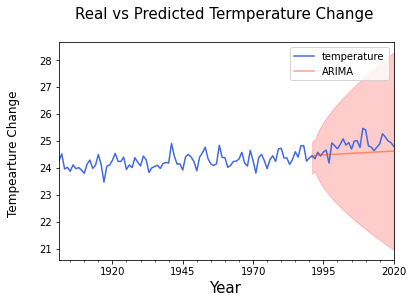

In [59]:
#observe real vs forecasted emissions values

#plot observed values
ax = df_India['1901-01-01':].plot(label='observed', color='royalblue', legend=True)

#plot predicted values
pred_mod.predicted_mean.plot(ax=ax, label='ARIMA', color='orangered', alpha=0.5, legend=True)

#add fill between lines, set axes labels and title
ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:, 1],
               color='r', alpha=0.2)

ax.set_xlabel('Year', size=15)
ax.set_ylabel('Tempearture Change \n', size=12)
ax.set_title('Real vs Predicted Termperature Change \n', size=15)

plt.legend()
plt.show()